In [20]:
import sys
import numpy as np
import cv2 as cv
from datetime import datetime

from PIL import Image

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import pickle

import pandas as pd
import glob as glob
import random

import os

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: ", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1").to(device)

Using device:  cuda


In [3]:
def img_transform(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.0
    img = torch.from_numpy(img).permute(2, 0, 1)
    return img

In [4]:
def inference(img, model, detection_threshold=0.70):
    '''
    Infernece of a single input image

    inputs:
    img: input-image as torch.tensor (shape: [C, H, W])
    model: model for infernce (torch.nn.Module)
    detection_threshold: Confidence-threshold for NMS (default=0.7)

    returns:
    boxes: bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    labels: class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    scores: confidence-score (Format [N] => N times confidence-score between 0 and 1)
    '''
    model.eval()

    img = img.to(device)
    outputs = model([img])

    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    labels = outputs[0]['labels'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    labels = labels[scores >= detection_threshold]
    scores = scores[scores >= detection_threshold]

    return boxes, scores, labels

In [5]:
import matplotlib.patches as patches

def plot_image(img, boxes, scores, labels, dataset, save_path=None):
    '''
    Function that draws the BBoxes, scores, and labels on the image.

    inputs:
        img: input-image as numpy.array (shape: [H, W, C])
        boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
        scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
        labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
        dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
    '''
    
    cmap = plt.get_cmap("tab20b")
    class_labels = np.array(dataset)
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    height, width, _ = img.shape
    
    fig, ax = plt.subplots(1, figsize=(16, 8))
    ax.imshow(img)
    
    for i, box in enumerate(boxes):
        class_pred = labels[i]
        conf = scores[i]
        width = box[2] - box[0]
        height = box[3] - box[1]
        rect = patches.Rectangle(
            (box[0], box[1]),
            width,
            height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(
            box[0], box[1],
            s = class_labels[int(class_pred)] + " " + str(int(100 * conf)) + "%",
            color = "white",
            verticalalignment = "top",
            bbox = {"color": colors[int(class_pred)], "pad": 0},
        )
        
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

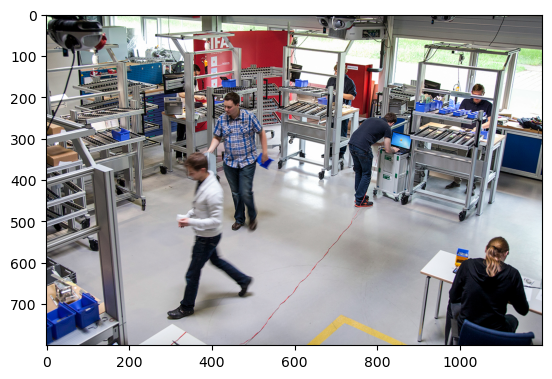

In [7]:
!wget https://www.uni-hannover.de/fileadmin/luh/studiengaenge/Produktion_und_Logistik_Master/produktion_und_logistik_master.jpg -q -O input.jpg
img = cv.imread("./input.jpg")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [8]:
img = img_transform(img)
boxes, scores, labels = inference(img, model)

/home/bersi/Documents/Academic_Stuff/MCV-DataContest/.conda/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [10]:
with open("./coco_labels.txt", "r") as coco:
  COCO_LABELS = coco.readlines()

for i, _ in enumerate(COCO_LABELS):
  COCO_LABELS[i] = COCO_LABELS[i].replace("\n", "")

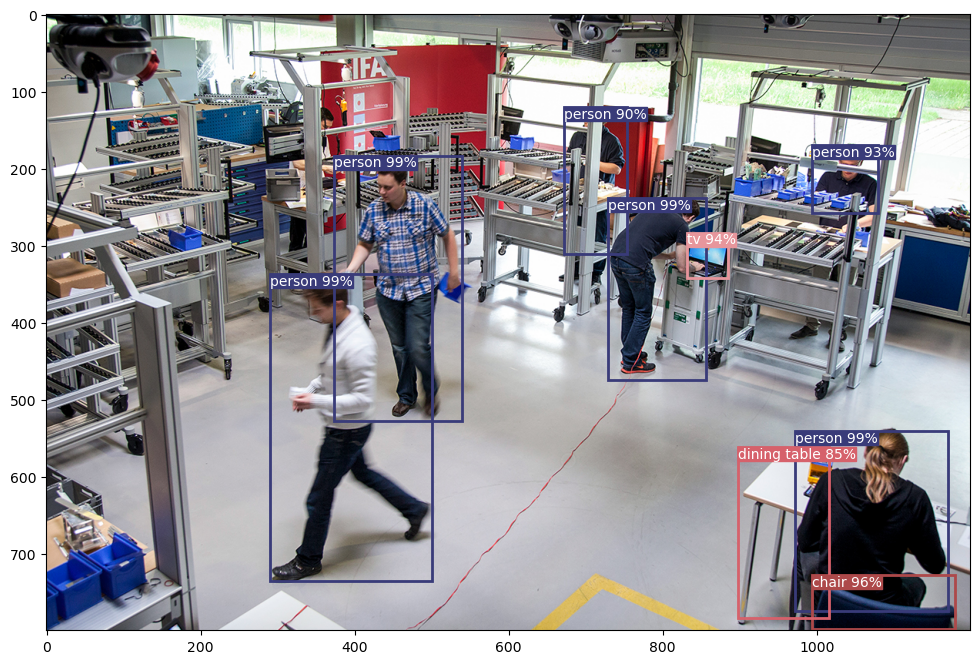

In [11]:
img = img.cpu().permute(1,2,0).numpy()
plot_image(img, boxes, scores, labels, COCO_LABELS)

In [17]:
IMG_DIR = "../../data_rcnn/images"
# LABELS_DIR = "../../data_rcnn/labels"
LABELS_FILE = "../../data_rcnn/labels_modded.csv"

df_new = pd.read_csv(LABELS_FILE)

# img_files = glob.glob(IMG_DIR + "/*.jpeg")

# for img in img_files:
#     img_name = img.split("/")[-1] # has ".jpeg" at the end
#     label_name = img_name.split(".")[0] + ".txt"
#     label_path = LABELS_DIR + "/" + label_name
#     with open(label_path, "r") as label:
#         lines = label.readlines()
#         for line in lines:
#             line = line.split(" ")
            
#             img = cv.imread(img)
#             width, height = img.shape[1], img.shape[0]
            
#             frame = img_name
#             label = line[0]
#             x, y, w, h = line[1:]
#             x, y, w, h = float(x), float(y), float(w), float(h)
#             x_min = int((x - w/2) * width)
#             y_min = int((y - h/2) * height)
#             x_max = int((x + w/2) * width)
#             y_max = int((y + h/2) * height)
            
#             df_new = pd.concat([df_new, 
#                                 pd.DataFrame([[x_min, y_min, x_max, y_max, frame, label]], 
#                                 columns=['xmin', 'ymin', 'xmax', 'ymax', 'Frame', 'Label'])])

In [19]:
'''
Class that holds all the augmentation related attributes
'''
class Transformation():
    # This provides a random probability of the augmentation to be applied or not
    def get_probability(self):
        return np.random.choice([False, True], replace=False, p=[0.5, 0.5])

    # Increases the contrast by a factor of 2
    def random_adjust_contrast(self, image, enable=None):
        enable = self.get_probability() if enable is None else enable
        return F.adjust_contrast(image, 2) if enable else image

    # Increaes the brightness by a factor of 2
    def random_adjust_brightness(self, image, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        return F.adjust_brightness(image,2) if enable else image

    # Horizontal flip
    def random_hflip(self, image, boxes, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        if enable:
          #flip image
          new_image = F.hflip(image)

          #flip boxes
          new_boxes = boxes.clone()
          new_boxes[:, 0] = image.shape[2] - boxes[:, 0]  # image width - xmin
          new_boxes[:, 2] = image.shape[2] - boxes[:, 2]  # image_width - xmax
          new_boxes = new_boxes[:, [2, 1, 0, 3]]          # Interchange the xmin and xmax due to mirroring
          return new_image, new_boxes
        else:
          return image, boxes

In [ ]:
class MosquitoDataset(Dataset):
    def __init__(self, img_path, label_path, classes, transforms = None):
        super.__init__()
        print("Preparing dataset...")
        
        self.image_dir = img_path
        self.gt_info = pd.read_csv(label_path)
        self.classes = classes
        self.transforms = transforms
        
        self.image_paths = glob.glob(self.image_dir + "/*.jpeg")
        all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(all_images)
        
        for i in range(len(self.gt_info)):
            label = self.gt_info.iloc[i, 'Label']
            self.gt_info.loc[i, 'Label'] = self.classes.index(label)
            
        print("Dataset prepared.")
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        target = ()
        
        image_name = self.all_images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = cv.imread(image_path)
        image = img_transform(image)
        
        gt_info = self.gt_info[self.gt_info['Frame'] == image_name]
        
        boxes = torch.Tensor(boxes[['xmin', 'ymin', 'xmax', 'ymax']].values).float()
        labels = torch.LongTensor(gt_info['Label'].values.tolist())
        
        if(self.transforms):
            image = self.transforms(image).random_adjust_contrast(image, enable=True)
            image = self.transforms(image).random_adjust_brightness(image, enable=True)
            image, boxes = self.transforms(image, boxes).random_hflip(image, boxes, enable=True)